# Visualize semantic change trajectory with diachronic word embeddings

In this notebook we will see how to visualize the semantic trajectory of a word across time slices, based on the changes in nearest neighbours from one time slice to the next. 

It goes without saying but, before starting, make sure you have trained and aligned diachronic embedding models. We assume that the embeddings were trained on OCR'd texts and they therefore contain OCR errors, which is why the `spellchecker` package is applied to attempt automatically reducing the number of mispellings showing up among the nearest neighbours. As we will see below, this step will likely not be enough to exclude all OCR errors, which is why a further (optional) step for manual cleaning will be introduced before the very last step that generates the visualization.

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from spellchecker import SpellChecker
spell = SpellChecker()

Create subdir for all outputs of this notebook if it does not exist already:

In [2]:
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

### Load pre-trained diachronic embeddings

Change the following to the path to the folder containing the aligned diachonic models:

In [3]:
pathtomodels = '../../outputs/lwmhmdwhole/aligned'

List all models in the folder and sort them (so that we can identify the most recent time slice):

In [4]:
allmodels = sorted(glob(f'{pathtomodels}/*.model'))

Load the model for the most recent time slice:

In [5]:
lastmodel = Word2Vec.load(allmodels[-1])

Get the 'name' of each time slice (retrieved from the name of the model):

In [6]:
slices_names = []
for i in range(len(allmodels)):
    slice_name = allmodels[i].split('/')[-1].split('.model')[0]
    slices_names.append(slice_name)

In [7]:
models = []
for model in tqdm(allmodels):
    modeltoappend = Word2Vec.load(model)
    models.append(modeltoappend)

100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


### Compare timeslices

It is recommended that a maximum of 4 timeslices are compared in the visualization. With more than that, you might find the plot cluttered and thus uninformative. Before visualizing the trajectory, it might be useful to run a change point detection algorithm, to check when a word might have undergone meaning change. You can check out the notebook [`changepoint_detection.ipynb`](./changepoint_detection.ipynb) if you'd like to try that first. Once you have identified potential change points, in order to get the visually clearest representation of the trajectory, you might want to try different time slices for the variable `timeslicestocompare`. For example, if your change point detection algorithm detected _1810s_ as a potential change point, you could try including _1800s_, _1820s_, as well as one or two time slices (if available) which are further away in time (before or after) from the detected change points (e.g. _1780s_ and _1850s_).

Below, change `keyword` to the word whose trajectory you wish to visualize. Then change `timeslicestocompare` to the relevant slices:

In [18]:
keyword = 'traffic'

timeslicestocompare = ['1800s','1810s','1840s','1860s']

timeslicesindeces = []
for slice in timeslicestocompare:
    index = slices_names.index(slice)
    timeslicesindeces.append(index)

Change the variable `topn` to how many nearest neighbours you'd like to include in the map. Note that eventually some of the _k_-nearest neighbours may not appear in the final map, as we will only visualize the union of all the nearest neighbours of the keyword across all time slices in `timeslicestocompare`, so that if a word is not in the vocabulary of all the time slices, it will be excluded. You will be able to check which of these have not been included by looking at the list `notpresent`.

In [19]:
topn = 20

In [20]:
vocab = []
for index in timeslicesindeces:
    print(f'Extracting from {slices_names[index]}...')
    keywordsim = models[index].wv.most_similar(positive=keyword, topn=topn)
    for i in keywordsim:
        vocab.append(i[0])
vocab = list(dict.fromkeys(vocab))

Extracting from 1800s...
Extracting from 1810s...
Extracting from 1840s...
Extracting from 1860s...


Run `spellchecker`:

In [21]:
newvocab = []
known = list(spell.known(vocab))
for word in vocab:
    if word in known:
        newvocab.append(word)
    else:
        item2 = spell.correction(word)
        if item2 != word:
            newvocab.append(item2)

newvocab = list(dict.fromkeys(newvocab))

The following cell lets you add any word which might not be included in the nearest 20 neighbours, but which you might wish to include in the map anyway. Uncomment and add your words in the list `bespoke` if you want to do so:

In [23]:
bespoke = ['canals', 'aqueducts','tunnels','drainage', 'navigation', 'waterworks']

newvocab = newvocab + bespoke
newvocab = list(dict.fromkeys(newvocab))

Likewise, if there are words or OCR errors not captured by `spellchecker` that you wish to manually remove from the map, uncomment and add those words in the list `tbr`:

In [24]:
tbr = ['offic', 'whilst', 'true', 'tree', 'shows']
for t in tbr:
    if t in newvocab:
        newvocab.remove(t)

In [25]:
fortsne = []
notpresent = []

for word in newvocab:
    if word != keyword:
        try:
            wordvecaverage = models[timeslicesindeces[-1]].wv[word]
            fortsne.append(wordvecaverage)
        except KeyError:
            notpresent.append(word)

newvocab = [x for x in newvocab if x not in notpresent]

for index in timeslicesindeces:
    fortsne.append(models[index].wv[keyword])

for slicename in timeslicestocompare:
    newvocab.append(f'{keyword}_{slicename}')

Now that we have the vectors for all the words that we will include in the map, we will reduce their dimensions with [`TSNE`](https://lvdmaaten.github.io/tsne/). In the next cell, define some of the important parameters ([here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for a complete list).

In [26]:
n_components = 2
random_state = 19051992 # For reproducibility
metric='euclidean'
learning_rate='auto'

Now generate the plot:

/Users/npedrazzini/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


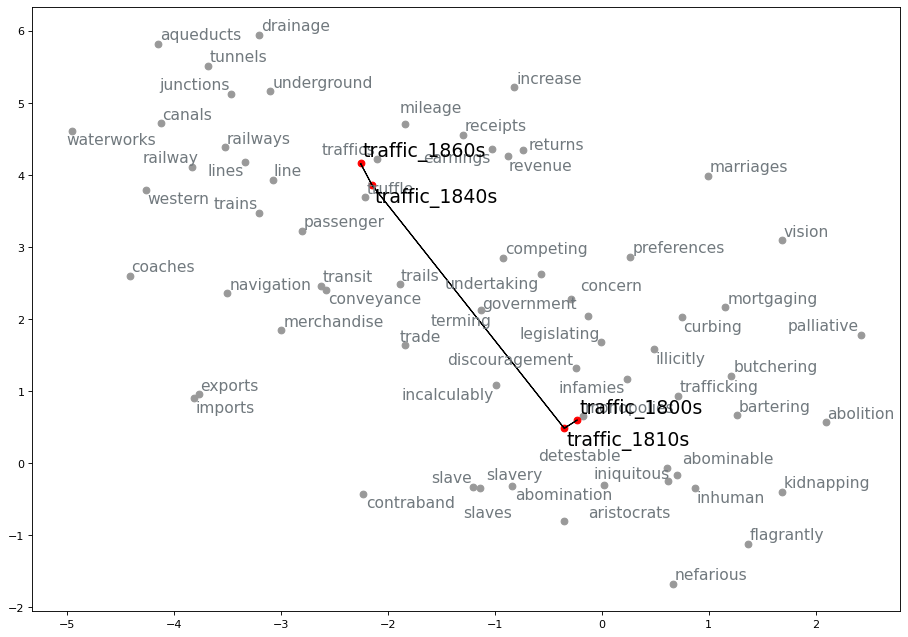

In [27]:
X = np.array(fortsne)

X_embedded = TSNE(n_components=n_components, random_state=random_state, metric=metric, learning_rate=learning_rate).fit_transform(X)

df = pd.DataFrame(X_embedded)

df2 = df.iloc[:-len(timeslicestocompare)]
df3 = df.iloc[-len(timeslicestocompare):]

df3 = df3.reset_index()

newvocab1 = newvocab[:-len(timeslicestocompare)]
newvocab1
newvocab2 = newvocab[-len(timeslicestocompare):]
newvocab2

x = df2[0] 
y = df2[1]
x2 = df3[0]
y2 = df3[1]

# just some size adjustment...
fig, ax = plt.subplots(1, figsize=(14,10),dpi=80,facecolor='#ffffff')
ax.set_facecolor('#ffffff')

# plot x and y
plt.scatter(x,y,c="0.6")

textsvocab = [plt.text(x[i], y[i], txt,color='#71797E',fontsize = 14) for i,txt in enumerate(newvocab1)]
adjust_text(textsvocab)

plt.scatter(x2,y2,c="red")

textsvocab2 = [plt.text(x2[i], y2[i], txt,color='black',fontsize = 17) for i,txt in enumerate(newvocab2)]
adjust_text(textsvocab2)

def drawArrow(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1], head_width=0.01, length_includes_head=True,color='black')

for i in range(1,len(timeslicestocompare)):
    X = np.array([x2[len(x2)-i],y2[len(y2)-i]])
    Y = np.array([x2[len(x2)-(i+1)],y2[len(y2)-(i+1)]])
    drawArrow(Y,X)

#show the plot
plt.savefig(f'{keyword}.png')
plt.show()
